In [44]:
import torch
from torchvision import datasets, transforms, models
from torchvision.transforms import v2
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
ROOT_DATA_PATH = "drive/MyDrive/Projeto Fine-Tuning CNN/chest_xray"

In [5]:
# Definindo as transformações para as imagens (pode ajustar conforme necessário)
transform_no_aug = transforms.Compose([
    transforms.Resize((120, 120)),  # Redimensiona as imagens para 120x120
    transforms.ToTensor(),          # Converte as imagens para tensores
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliza com valores usados por redes pré-treinadas
])

# Definindo as transformações para as imagens (pode ajustar conforme necessário)
transform_aug = transforms.Compose([
    transforms.Resize((120, 120)),  # Redimensiona as imagens para 120x120
    transforms.RandomHorizontalFlip(0.2), # Rotaciona a imagem horizontalmente
    transforms.RandomPerspective(0.1), # Mudança de perspectiva aleatoriamente
    transforms.ToTensor(),          # Converte as imagens para tensores
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normaliza com valores usados por redes pré-treinadas
])

In [7]:
# Defina o caminho para os diretórios de treino, teste e validação
train_dir = datasets.ImageFolder(f'{ROOT_DATA_PATH}/train')
test_dir = datasets.ImageFolder(f'{ROOT_DATA_PATH}/test')
val_dir = datasets.ImageFolder(f'{ROOT_DATA_PATH}/val')

# Combine os datasets de treino, teste e validação
full_dataset = torch.utils.data.ConcatDataset([train_dir, test_dir, val_dir])

# Obtenha os targets de todas as pastas para aplicar a estratificação
all_targets = train_dir.targets + test_dir.targets + val_dir.targets

# Obtenha os índices do dataset combinado
dataset_size = len(full_dataset)
indices = list(range(dataset_size))

# Divida os índices em 80% para treino e 20% para validação
train_indices, valid_indices = train_test_split(indices, test_size=0.2, stratify=all_targets)

# Crie os subsets para treino e validação
train_dataset = Subset(full_dataset, train_indices)
valid_dataset = Subset(full_dataset, valid_indices)

# Aplique as transformações específicas
for ds in train_dataset.dataset.datasets:
    ds.transform = transform_aug

for ds in valid_dataset.dataset.datasets:
    ds.transform = transform_no_aug

# Crie os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(f'Treino: {len(train_dataset)}')
print(f'Validação: {len(valid_dataset)}')

Treino: 4684
Validação: 1172


In [15]:
from collections import Counter

# Obtenha os valores únicos em all_targets
unique_targets = set(all_targets)

# Conte as ocorrências de cada target
target_counts = Counter(all_targets)

# Exiba os valores únicos e suas contagens
print("Valores únicos em all_targets:", unique_targets)
print("Contagem de cada target:")
for target, count in target_counts.items():
    print(f'Target {target}: {count}')


Valores únicos em all_targets: {0, 1}
Contagem de cada target:
Target 0: 1583
Target 1: 4273


In [16]:
def show_test_example(data_loader):
    """
    Exibe um exemplo de imagem e seu rótulo a partir de um DataLoader.

    Parâmetros:
    data_loader (torch.utils.data.DataLoader): O DataLoader contendo as imagens e rótulos.
    """
    # Obtenha um lote de dados do DataLoader
    dataiter = iter(data_loader)
    images, labels = next(dataiter)

    # Selecione uma imagem do lote
    img = images[0]
    label = labels[0]

    # Desnormalize a imagem (se necessário)
    img = img / 2 + 0.5  # Desfaz a normalização para o intervalo [0, 1]

    # Converta para numpy
    npimg = img.numpy()

    # Transponha as dimensões de (C, H, W) para (H, W, C)
    npimg = np.transpose(npimg, (1, 2, 0))

    # Mostre a imagem
    plt.imshow(npimg)
    plt.title(f'Label: {label}')
    plt.show()

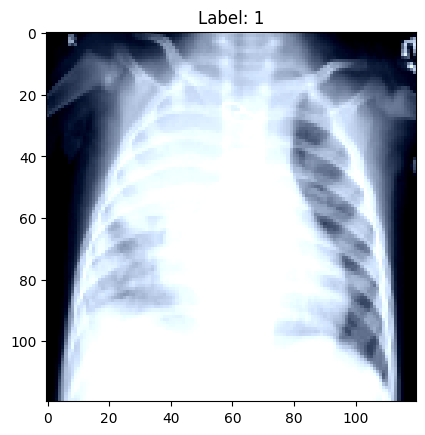

In [17]:
show_test_example(train_loader)

In [18]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


In [19]:
weights = models.ResNet50_Weights.IMAGENET1K_V1
model = models.resnet50(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.8MB/s]


In [20]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [21]:
# Congelando todas as camadas do modelo
for param in model.parameters():
    param.requires_grad = False

In [22]:
# Substituindo a camada de classificação
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

In [23]:
model.fc

Linear(in_features=2048, out_features=2, bias=True)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
history = train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 147/147 [38:38<00:00, 15.77s/it]


Epoch 1, Train Loss: 0.255, Train Accuracy: 89.84%
Epoch 1, Val Loss: 0.184, Val Accuracy: 92.58%


100%|██████████| 147/147 [08:59<00:00,  3.67s/it]


Epoch 2, Train Loss: 0.222, Train Accuracy: 91.10%
Epoch 2, Val Loss: 0.186, Val Accuracy: 92.32%


100%|██████████| 147/147 [08:52<00:00,  3.62s/it]


Epoch 3, Train Loss: 0.188, Train Accuracy: 92.34%
Epoch 3, Val Loss: 0.174, Val Accuracy: 93.17%


100%|██████████| 147/147 [09:06<00:00,  3.72s/it]


Epoch 4, Train Loss: 0.177, Train Accuracy: 93.51%
Epoch 4, Val Loss: 0.169, Val Accuracy: 93.60%


100%|██████████| 147/147 [09:00<00:00,  3.67s/it]


Epoch 5, Train Loss: 0.174, Train Accuracy: 93.49%
Epoch 5, Val Loss: 0.176, Val Accuracy: 93.34%
Treinamento concluído


In [27]:
# torch.save(model.state_dict(), 'treined_weights.pth')

In [ ]:
# model.load_state_dict(torch.load('treined_weights.pth'))

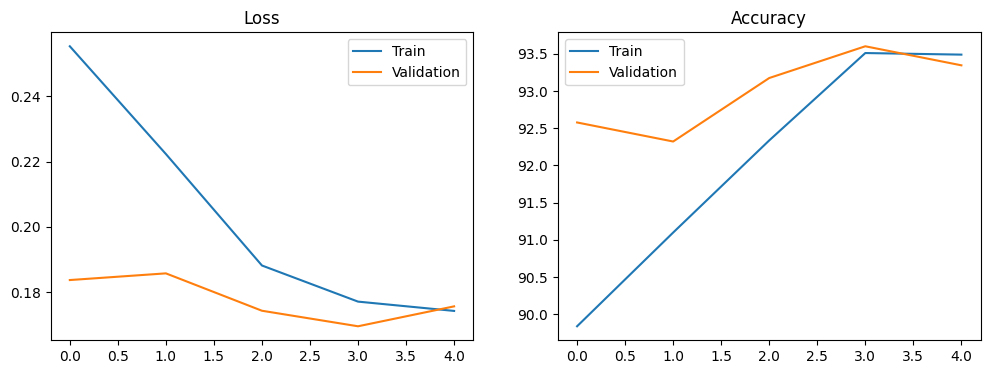

In [28]:
plot_history(history)

In [31]:
test_model(model, valid_loader)

Acurácia da rede na base de teste: 93.34%


In [46]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

# Assuming original_dataset is the dataset instance with the classes attribute
def get_random_samples(dataset, num_samples):
    indices = random.sample(range(len(dataset)), num_samples)
    return [dataset[i] for i in indices]

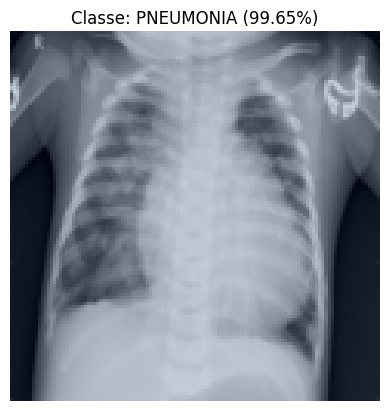

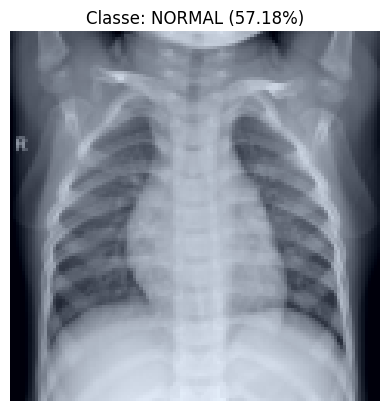

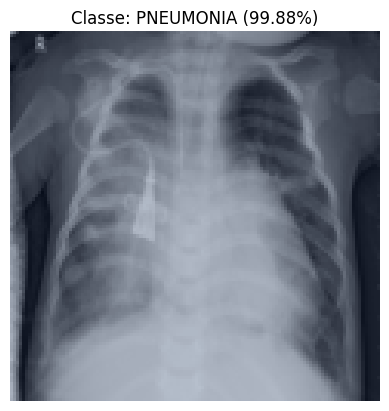

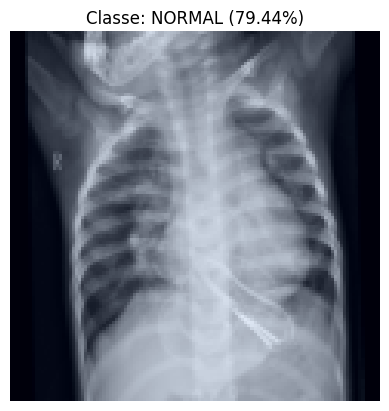

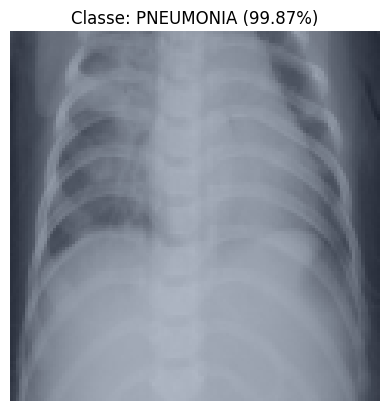

In [52]:
# Use the original dataset to get class names
class_names = val_dir.classes

# Get random samples from the dataset
dataset_samples = get_random_samples(valid_dataset.dataset, num_samples=5)

for image, label in dataset_samples:
    plot_and_predict(model, image, class_names)